We will:
1. Prepare text for LLM training.
2. Split text into word and sub-word tokens.
3. Byte-pair encoding (BPE) to tokenize the text.
4. Sampling training examples with a sliding window.
5. Convert tokens into vectors that feed into the LLM.

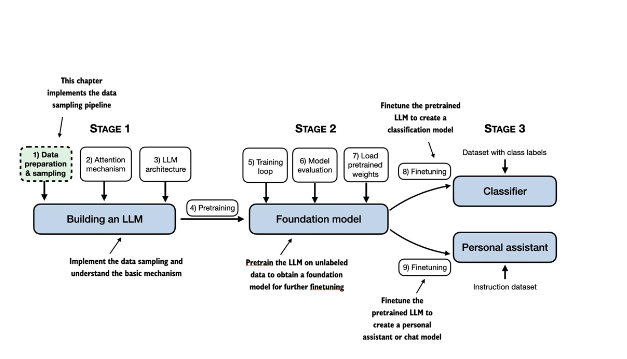

Deep neural network models, including LLMs, cannot process raw text
directly. Since text is categorical, it isn't compatible with the mathematical
operations used to implement and train neural networks. Therefore, we need a
way to represent words as continuous-valued vectors. 

The concept of converting data into a vector format is often referred to as embedding. Using a specific neural network layer or another pretrained neural network model, we can embed different data types, for example, video, audio, and text

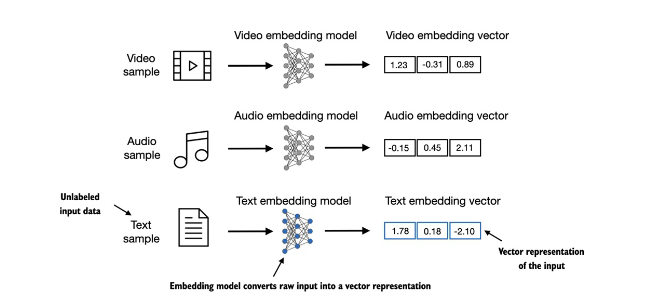

It's important to note that different data formats require distinct embedding models. For example, an embedding model designed for text would not be suitable for embedding audio or video data.

At its core, an embedding is a mapping from discrete objects, such as words, images, or even entire documents, to points in a continuous vector space -- the primary purpose of embeddings is to convert non-numeric data into a format that neural networks can process.
While word embeddings are the most common form of text embedding, there are also embeddings for sentences, paragraphs, or whole documents. Sentence or paragraph embeddings are popular choices for retrieval-augmented generation. Retrieval-augmented generation combines generation (like producing text) with retrieval (like searching an external knowledge base) to pull relevant information when generating text, which is a technique that is beyond the scope of this book. Since our goal is to train GPT-like LLMs, which learn to generate text one word at a time, we focus on word embeddings.

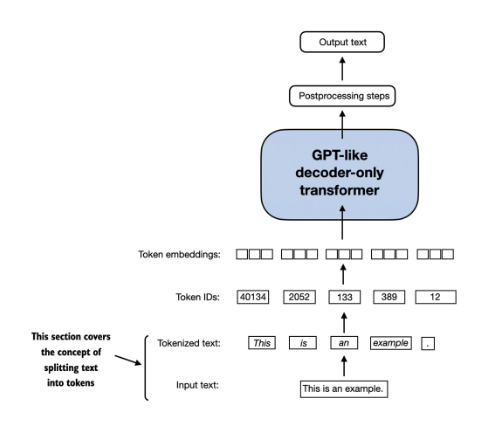

In [1]:
with open("./the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()
print("Total characters in the text:", len(raw_text))
print("First 100 characters of the text:", raw_text[:100])

Total characters in the text: 20479
First 100 characters of the text: I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


Our goal is to tokenize this 20,479-character short story into individual words
and special characters that we can then turn into embeddings for LLM
training

In [2]:
# using sample text, we can user the re.split function to split the text into words
import re
text = "Hello, world! This is a test."
result = re.split(r'(\s)', text)
print("Split text:", result)

Split text: ['Hello,', ' ', 'world!', ' ', 'This', ' ', 'is', ' ', 'a', ' ', 'test.']


this result is a list of individual words, whitespaces, and punctuation marks. We will refrain from making all text lowercase because capitalization helps LLMs distinguish between proper nouns and common nouns, understand sentence structure, and learn to generate text with proper
capitalization.

In [3]:
# modifying the regular expression splits on whitespaces (\s) and commas and periods

result = re.split(r'(\s|[,.])', text)
print(result)

['Hello', ',', '', ' ', 'world!', ' ', 'This', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


A small remaining issue is that the list still includes whitespace characters.
Optionally, we can remove these redundant characters safely as follows:

In [4]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world!', 'This', 'is', 'a', 'test', '.']


Let's modify it a bit further so that it can also handle other types of
punctuation, such as question marks, quotation marks, and the double-dashes
we have seen earlier in the first 100 characters of Edith Wharton's short story,
along with additional special characters:


In [5]:
text = "Hello, world! This is a test."
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print("Final split text:", result)

Final split text: ['Hello', ',', 'world', '!', 'This', 'is', 'a', 'test', '.']


In [6]:
# now we apply it to the text from the file

preprocessed = re.split(r'([,.?_!"()\']|--|\s)', raw_text)
preprocessed_text = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed_text), "tokens in the preprocessed text.")

4649 tokens in the preprocessed text.


In [7]:
print("Preprocessed text:", preprocessed_text[:100])  # Display first 100 tokens for brevity

Preprocessed text: ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in', 'the', 'height', 'of', 'his', 'glory', ',', 'he', 'had', 'dropped', 'his', 'painting', ',', 'married', 'a', 'rich', 'widow', ',', 'and', 'established', 'himself', 'in', 'a', 'villa', 'on', 'the', 'Riviera', '.', '(', 'Though', 'I', 'rather', 'thought', 'it', 'would', 'have', 'been', 'Rome', 'or', 'Florence', '.', ')', '"', 'The', 'height', 'of', 'his', 'glory', '"', '--', 'that', 'was', 'what', 'the', 'women', 'called', 'it', '.', 'I', 'can', 'hear', 'Mrs', '.', 'Gideon', 'Thwing', '--', 'his', 'last', 'Chicago', 'sitter', '--']


Converting tokens into token IDs

to map the previously created tokens to their corresponding IDs, we need a vocabulary that contains all the unique tokens in the text. The vocabulary is a dictionary where each token is associated with a unique integer ID. This mapping allows us to convert the tokens into numerical representations that can be processed by the LLM.

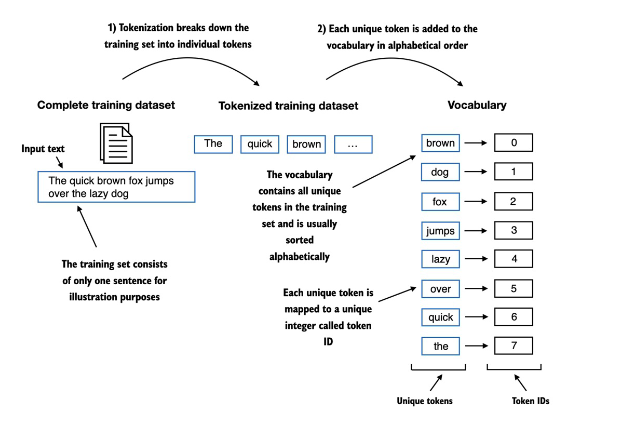

In [8]:
all_words = sorted(list(set(preprocessed_text)))
vocab_size = len(all_words)
print("Vocabulary size:", vocab_size)

Vocabulary size: 1159


In [9]:
vocab = {token: integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i > 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Carlo;', 25)
('Chicago', 26)
('Claude', 27)
('Come', 28)
('Croft', 29)
('Destroyed', 30)
('Devonshire', 31)
('Don', 32)
('Dubarry', 33)
('Emperors', 34)
('Florence', 35)
('For', 36)
('Gallery', 37)
('Gideon', 38)
('Gisburn', 39)
('Gisburns', 40)
('Grafton', 41)
('Greek', 42)
('Grindle', 43)
('Grindle:', 44)
('Grindles', 45)
('HAD', 46)
('Had', 47)
('Hang', 48)
('Has', 49)
('He', 50)
('Her', 51)


In [10]:
# now we will create a simple tokenizer with an encode and decode method to convert text to token IDs and vice versa

class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
            preprocessed_text = re.split(r'([,.?_!"()\']|--|\s)', text)
            preprocessed_text = [item.strip() for item in preprocessed_text if item.strip()]
            ids = [self.str_to_int[s] for s in preprocessed_text]
            return ids

    def decode(self, ids):
            text = " ".join([self.int_to_str[i] for i in ids])
            text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
            return text

In [11]:
tokenizer = SimpleTokenizerV1(vocab)

text = """It's the last he painted, you know," Mrs. Gisburn said."""
ids = tokenizer.encode(text)
print("Encoded IDs:", ids)

Encoded IDs: [58, 2, 872, 1013, 615, 541, 763, 5, 1155, 608, 5, 1, 69, 7, 39, 873, 7]


In [12]:
# now we use the decode method to convert the IDs back to text
decoded_text = tokenizer.decode(ids)
print("Decoded text:", decoded_text)

Decoded text: It' s the last he painted, you know," Mrs. Gisburn said.


In [13]:
# let us try to tokenize a sample text that is not part of the original text
text = "Hello, do you like tea? I do!"
tokenizer.encode(text)

KeyError: 'Hello'

The problem is that the word "Hello" was not used in the The Verdict short
story. Hence, it is not contained in the vocabulary. This highlights the need to
consider large and diverse training sets to extend the vocabulary when
working on LLMs.

Adding special context tokens

Here we will modify the previous tokenizer to include special context tokens like unknown words.

In [14]:
all_tokens = sorted(list(set(preprocessed_text)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token: integer for integer, token in enumerate(all_tokens)}
print("length of vocabulary with special tokens:", len(vocab.items()))

length of vocabulary with special tokens: 1161


In [15]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1156)
('your', 1157)
('yourself', 1158)
('<|endoftext|>', 1159)
('<|unk|>', 1160)


now we adjust the previous tokenizer to include special context tokens like unknown words. This is important because it allows the model to handle words that were not present in the training data, which is a common scenario in real-world applications.

In [16]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed_text = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed_text = [item.strip() for item in preprocessed_text if item.strip()]
        preprocessed_text = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed_text
        ]

        ids = [self.str_to_int[s] for s in preprocessed_text]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [17]:
text1 = "Hello, do you like tea? I do!"
text2 = "In the sunlight terraces of the palace."

text = " <|endoftext|> ".join([text1, text2])
print("Combined text:", text)

Combined text: Hello, do you like tea? I do! <|endoftext|> In the sunlight terraces of the palace.


In [18]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1160, 5, 362, 1155, 642, 1000, 10, 55, 362, 0, 1159, 57, 1013, 1160, 1009, 738, 1013, 1160, 7]


In [19]:
print("Decoded text:", tokenizer.decode(tokenizer.encode(text)))

Decoded text: <|unk|>, do you like tea? I do! <|endoftext|> In the <|unk|> terraces of the <|unk|>.


Byte-Pair Encoding (BPE)

next we will implement a more sophisticated tokenization
scheme based on a concept called byte pair encoding (BPE). The BPE tokenizer covered in this section was used to train LLMs such as GPT-2, GPT-3, and the original model used in ChatGPT.

In [20]:
# !pip install -qU tiktoken

In [21]:
from importlib.metadata import version
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.12.0


In [22]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [23]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of some"
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617]


In [24]:
strings = tokenizer.decode(integers)
print("Decoded text:", strings)

Decoded text: Hello, do you like tea? <|endoftext|> In the sunlit terraces of some


#### Data sampling with a sliding window
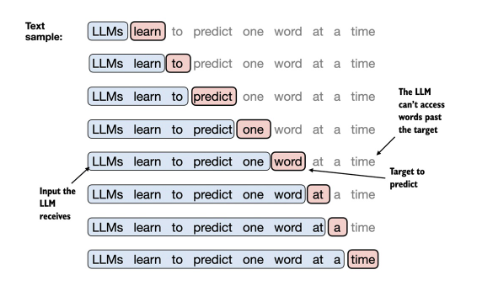

we will now implement a datloader that fetches input-target pairs from the training dataset using a sliding window approach. This method allows us to create overlapping sequences of tokens, which is essential for training LLMs effectively. The sliding window technique helps the model learn context and relationships between words in the text, improving its ability to generate coherent and contextually relevant responses.

In [25]:
with open("./the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()
enc_text = tokenizer.encode(raw_text)
print("Encoded text length:", len(enc_text))

Encoded text length: 5145


In [26]:
# using a sample text size of 50 tokens for demonstration

enc_sample = enc_text[:50]

In [27]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")

x: [40, 367, 2885, 1464]
y:      [367, 2885, 1464, 1807]


In [28]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    target = enc_sample[i]
    print(context, "----->", target)

[40] -----> 367
[40, 367] -----> 2885
[40, 367, 2885] -----> 1464
[40, 367, 2885, 1464] -----> 1807


In [29]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    target = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([target]))

I ---->  H
I H ----> AD
I HAD ---->  always
I HAD always ---->  thought


In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

# creating a custom dataset class for GPT training
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [31]:
# the following will use the GPTDatasetV1 class to load the input in batches

def create_dataloaderv1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=False):

    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader

In [32]:
# testing the dataloader with a batch size of 1 for an llm with a context size of 4

with open("./the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()
dataloader = create_dataloaderv1(raw_text, batch_size=1, max_length=4, stride=1)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print("Input IDs:", first_batch[0])
print("Target IDs:", first_batch[1])

Input IDs: tensor([[2655,   12, 8439,  274]])
Target IDs: tensor([[  12, 8439,  274,  438]])


In [33]:
second_batch = next(data_iter)
print("Input IDs:", second_batch[0])
print("Target IDs:", second_batch[1])

Input IDs: tensor([[ 674, 1611,  286, 1242]])
Target IDs: tensor([[1611,  286, 1242,  526]])


In [34]:
# looking at how to use the dataloader to sample with  a batch size greater than 1

dataloader = create_dataloaderv1(raw_text, batch_size=8, max_length=4, stride=4)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Input IDs:", inputs)
print("Target IDs:", targets)

Input IDs: tensor([[  286,  3703,    13,  9074],
        [  502,    11,   290,   284],
        [   11, 10371,   257,  1534],
        [19133,   553,   373,   530],
        [  351,  1602, 11227,   414],
        [   13,   198,   198,     1],
        [  938,   475,   530,   553],
        [ 1675,   262,  6846,    11]])
Target IDs: tensor([[ 3703,    13,  9074,    13],
        [   11,   290,   284,  3285],
        [10371,   257,  1534,  4241],
        [  553,   373,   530,   286],
        [ 1602, 11227,   414,    13],
        [  198,   198,     1,  5779],
        [  475,   530,   553,   673],
        [  262,  6846,    11,   314]])


Creating token embeddings

the last step in preparing the data for training an LLM is to convert the tokens into embeddings. Token embeddings are continuous vector representations of tokens that capture their semantic meaning and relationships. These embeddings are essential for the LLM to understand and generate text effectively.

In [35]:
# suppose we have the following four input ids (after tokenization)
input_ids = ([2, 3, 5, 1])

In [36]:
vocab_size = 6
output_dim = 3

torch.manual_seed(42)  # For reproducibility
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [37]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 1.9269,  1.4873, -0.4974],
        [ 0.4396, -0.7581,  1.0783],
        [ 0.8008,  1.6806,  0.3559],
        [-0.6866,  0.6105,  1.3347],
        [-0.2316,  0.0418, -0.2516],
        [ 0.8599, -0.3097, -0.3957]], requires_grad=True)


In [38]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [39]:
max_length = 4
dataloader = create_dataloaderv1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [40]:
print("Token ids:", inputs)
print("\nInput shape:\n", inputs.shape)

Token ids: tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Input shape:
 torch.Size([8, 4])


In [41]:
token_embeddings = token_embedding_layer(inputs)
print("Token embeddings shape:", token_embeddings.shape)

Token embeddings shape: torch.Size([8, 4, 256])


In [42]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

print(pos_embedding_layer.weight)

Parameter containing:
tensor([[ 1.2192, -0.2741,  0.6823,  ..., -2.0313, -0.3160, -0.2499],
        [ 0.1600, -2.1962,  0.4126,  ..., -1.1532,  0.4579,  1.3812],
        [-0.1451,  0.5679,  0.1859,  ...,  0.2771, -1.2594,  1.3905],
        [ 1.3473, -0.5042, -0.2962,  ...,  0.7891,  1.0097, -0.0340]],
       requires_grad=True)


In [43]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [44]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
print(input_embeddings)

torch.Size([8, 4, 256])
tensor([[[ 0.9929,  1.2730,  2.4816,  ..., -3.1044, -1.0006, -1.4009],
         [ 0.2024, -1.5256,  3.4631,  ...,  0.5621,  0.5827,  1.8916],
         [-0.2273,  0.8504,  0.1607,  ..., -1.0865, -0.4518,  0.8350],
         [ 1.0354, -1.0111,  0.3602,  ...,  1.2152,  0.3235,  0.1452]],

        [[ 0.4168, -0.8053,  1.0236,  ..., -2.7059, -0.8447,  0.2327],
         [-0.8017, -3.5029,  1.3730,  ..., -0.5651,  0.5725,  2.5869],
         [ 0.1072, -0.5381,  0.0403,  ...,  0.0164, -1.4713,  2.7003],
         [ 0.6136, -1.2564, -1.5048,  ..., -0.1503,  0.3037, -1.2837]],

        [[ 2.1066,  1.1299,  0.2476,  ..., -2.9739, -1.6134, -0.9502],
         [ 1.6877, -0.9194,  0.9621,  ..., -0.9311, -0.7371,  1.2539],
         [ 1.0806,  0.7711,  1.5023,  ...,  0.5542, -1.7788,  1.3063],
         [ 0.2958, -1.6481,  1.1100,  ...,  0.6679,  0.2085, -0.3307]],

        ...,

        [[ 1.6635, -0.8945,  0.3051,  ..., -2.9925,  1.4646,  2.0344],
         [-0.2900, -0.8169, -0.01